# Dependencies

In [1]:
!pip install numpy
!pip install pandas
!pip install torch
!pip install transformers
!pip install scikit-learn
!pip install wordcloud

In [2]:
!nvidia-smi

Fri Jun 30 20:28:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [3]:
import torch
from sklearn.model_selection import train_test_split
from transformers import GPT2LMHeadModel, get_scheduler, GPT2Tokenizer
from torch.utils.data import DataLoader, Dataset

# Constants

In [4]:
from google.colab import drive
GOOGLE_DRIVE_BASE_DIR = "/content/drive/MyDrive/TPs/Quinto/NLP"
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Trump tweets generation

In [5]:
trump_file_path = f"{GOOGLE_DRIVE_BASE_DIR}/trump_tweets.txt"
biden_file_path = f"{GOOGLE_DRIVE_BASE_DIR}/biden_tweets.txt"

In [27]:
biden = open(biden_file_path, encoding="UTF-8").read().splitlines()
# trump = open(trump_file_path, encoding="UTF-8").read().splitlines()

seed = 40

train_data, test_data = train_test_split(biden, test_size=0.3, random_state=seed)

test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=seed)

# Initialize the GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer.add_special_tokens({
  "eos_token": "</s>",
  "bos_token": "<s>",
  "unk_token": "<unk>",
  "pad_token":  tokenizer.eos_token,
  "mask_token": "<mask>"
})

train_tokenized = tokenizer(train_data, padding="max_length", truncation=True, max_length=128)
val_tokenized = tokenizer(val_data, padding="max_length", truncation=True, max_length=128)
test_tokenized = tokenizer(test_data, padding="max_length", truncation=True, max_length=128)

class TweetDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, index):
        return {key: torch.tensor(val[index]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)


train_dataset = TweetDataset(train_tokenized)
val_dataset = TweetDataset(val_tokenized)
test_dataset = TweetDataset(test_tokenized)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

max_epochs = 10

# Filtered trump tweets: 879
# Filtered biden tweets: 439

In [7]:
def train_model(model, max_epochs, optimizer, scheduler, layers_freezed):
    for epoch in range(max_epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["input_ids"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        loss_map[f'freezed_{layers_freezed}'].append(avg_train_loss)
        print(f"Epoch {epoch + 1}: Average training loss = {avg_train_loss}")

        # Evaluate on the validation set
        model.eval()
        eval_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = input_ids.clone().detach()

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(val_loader)
        print(f"Epoch {epoch + 1}: Average validation loss = {avg_eval_loss}")

    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = input_ids.clone().detach()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test loss: {avg_test_loss}")

    return model

In [28]:
loss_map = {}
models = []

device = f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu"

layers_to_freeze = [0]
for freeze in layers_to_freeze:
  loss_map[f"freezed_{freeze}"] = []

  model = GPT2LMHeadModel.from_pretrained('gpt2')
  model.to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
  scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=max_epochs * len(train_loader))

  print(f"### Freezing {freeze} Layers ###")
  for i in range(freeze):
    for param in model.transformer.h[i].parameters():
      param.requires_grad = False

  print("### Training ###")
  models.append(train_model(model, max_epochs, optimizer, scheduler, freeze))

### Freezing 0 Layers ###
### Training ###
Epoch 1: Average training loss = 5.177712512016297
Epoch 1: Average validation loss = 2.92246421178182
Epoch 2: Average training loss = 2.2437941670417785
Epoch 2: Average validation loss = 1.802321473757426
Epoch 3: Average training loss = 1.7931240439414977
Epoch 3: Average validation loss = 1.7129644950230916
Epoch 4: Average training loss = 1.749138605594635
Epoch 4: Average validation loss = 1.6915632883707683
Epoch 5: Average training loss = 1.7124712228775025
Epoch 5: Average validation loss = 1.6701237360636394
Epoch 6: Average training loss = 1.6803171277046203
Epoch 6: Average validation loss = 1.654006044069926
Epoch 7: Average training loss = 1.653288149833679
Epoch 7: Average validation loss = 1.6428102254867554
Epoch 8: Average training loss = 1.6378388166427613
Epoch 8: Average validation loss = 1.6355796655019124
Epoch 9: Average training loss = 1.6293989181518556
Epoch 9: Average validation loss = 1.6312999725341797
Epoch 10: 

In [9]:
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

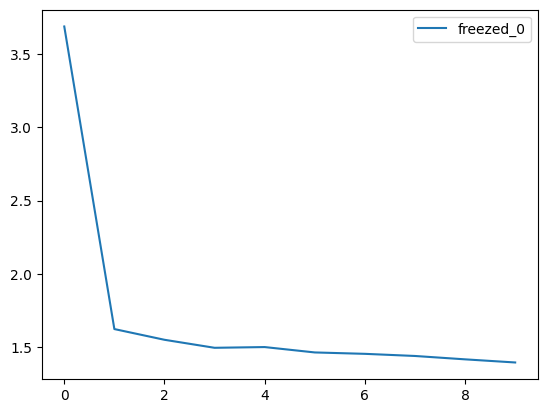

In [10]:
for k, v in loss_map.items():
  plt.plot(v, label = k)

plt.legend()
plt.show()

In [29]:
prompt = "Biden is"
max_length = 140
models[0].eval()
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

generated_tweets = []

for i in range(100):
  output = models[0].generate(
      input_ids=input_ids,
      do_sample=True,
      num_return_sequences=4,
      temperature=0.9,
      max_length=max_length,
      top_k=50,
      top_p=0.95,
  )

  for tweet in output:
    generated_tweets.append(tokenizer.decode(tweet, skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [20]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import string
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
def preprocess_and_lemmatize(text):
    # Tokenización de palabras y convertir texto a minúsculas
    tokens = word_tokenize(text.lower())
    # Filtrar signos de puntuación
    tokens = [token for token in tokens if token not in punctuation]
    # Lematización de palabras
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Unir tokens lematizados en una cadena de texto
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
tweets = []

for tweet in generated_tweets:
  tweets.append(tweet.splitlines())

tweets = [item for sublist in tweets for item in sublist]

sia = SentimentIntensityAnalyzer()

negative_tweets = []
for tweet in tweets:
   sentiment_scores = sia.polarity_scores(tweet)
   if sentiment_scores['neg'] > 0.3:
    print(tweet)
    negative_tweets.append(tweet)



Biden is already calling his new strategy "a very dangerous, very stupid idea".
Biden is an idiot but he's an idiot nonetheless.
Biden is no stranger to controversy, particularly from conservatives. He also has called Donald Trump a fraud and a fraud. He called Obama a crook and a fraud.
Biden is also being accused of sexual assault by one of his accusers, and he is also accused of sexual assault by a female employee of his office.
Biden is going to have no regrets.
Biden is now just out of prison.
Biden is right to say Obamacare is a failure. But he also knows it's a failure, a failure, and not just for Republicans.
Biden is so wrong and his party needs to realize that he's wrong.
Biden is not happy with the outcome.
Biden is a liar who lies when he says he's going to have a president who would stop the terrorists from going around the country and start to deport the immigrants we hate, and he will stop those terrorists.
Biden is not just a Republican. He's also an anti-democratic, ra

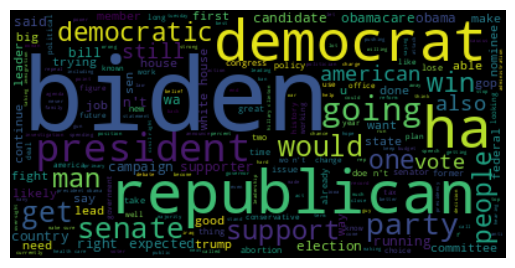

In [34]:
# Obtener lista de signos de puntuación
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

preprocessed_tweets = [preprocess_and_lemmatize(tweet) for tweet in generated_tweets]

processed_tweets = ' '.join(preprocessed_tweets).strip()

wordcloud = WordCloud(stopwords=stop_words).generate(processed_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()